In [1]:
## Imports
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
from statsmodels.formula.api import ols
from latlon_utils import get_climate, get_data_dir
from matplotlib.colors import ListedColormap

sys.path.append('..')
from LAD import LAD, BinnedLAD, confidence_interval_from_extreme_regions

# Prep roi-WBD-NAHL
Create subset version of main data file with only WBD-NAHL ROI lakes.

In [2]:
df_HL_jn_full_pth = '/Volumes/thebe/Ch4/GSW_zonal_stats/HL/v4/HL_zStats_Oc_full.csv.gz'
gdf_HL_jn_pth = '/Volumes/thebe/Ch4/GSW_zonal_stats/HL/v3/HL_zStats_Oc_binned_jnBAWLD_roiNAHL.shp' # gives ROI
df_HL_BAWLD_NAHL_jn_full_pth = '/Volumes/thebe/Ch4/GSW_zonal_stats/HL/v4/HL_zStats_Oc_full_jnBAWLD_roiNAHL.csv.gz' # Output: main data source # HL clipped to BAWLD and WBD


## Load, if needed
gdf_hl = pd.read_csv(df_HL_jn_full_pth, compression='gzip')
gdf_roi = gpd.read_file(gdf_HL_jn_pth) # gives indexes of lakes in ROI


/var/folders/rv/sn0kln2103b9fs4xl56n3w7w0000gn/T/ipykernel_47048/3394725772.py:7: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  gdf_hl = pd.read_csv(df_HL_jn_full_pth, compression='gzip')


KeyboardInterrupt: 

In [ ]:
gdf_roi.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 754832 entries, 0 to 754831
Data columns (total 17 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   Hylak_id    754832 non-null  int64   
 1   0-5         754832 non-null  float64 
 2   5-50        754832 non-null  float64 
 3   50-95       754832 non-null  float64 
 4   95-100      754832 non-null  float64 
 5   Class_sum   754832 non-null  float64 
 6   Shp_Area    754832 non-null  float64 
 7   BAWLDCell_  754832 non-null  int64   
 8   n           754832 non-null  int64   
 9   distance    754832 non-null  float64 
 10  feature_x   754832 non-null  float64 
 11  feature_y   754832 non-null  float64 
 12  nearest_x   754832 non-null  float64 
 13  nearest_y   754832 non-null  float64 
 14  BAWLDLong   754832 non-null  float64 
 15  BAWLDLat    754832 non-null  float64 
 16  geometry    754832 non-null  geometry
dtypes: float64(13), geometry(1), int64(3)
memory usage: 97.9 MB

In [ ]:
gdf_hl = gdf_hl.drop(columns=['Unnamed: 0', 'system:index']).merge(gdf_roi['Hylak_id'], on='Hylak_id', how='inner')

In [ ]:
gdf_hl

,Class_70,Class_71,Class_72,Class_73,Class_74,Class_75,Class_76,Class_77,Class_sum,Class_8,...,Elevation,Vol_res,Dis_avg,Pour_lat,Vol_src,Country,Lake_name,Class_98,Class_99,Class_100
0,0.003,0.000,0.000,0.001,0.001,0.001,0.000,0.003,0.363,0.001,...,621.0,0.0,0.005,50.490288,3.0,Canada,NaN,NaN,NaN,NaN
1,0.000,0.000,0.000,0.000,0.001,0.001,0.000,0.002,0.109,0.001,...,630.0,0.0,0.001,50.485042,3.0,Canada,NaN,NaN,NaN,NaN
2,0.002,0.000,0.001,0.000,0.001,0.001,0.002,0.001,0.323,0.000,...,613.0,0.0,0.006,50.492419,3.0,Canada,NaN,NaN,NaN,NaN
3,0.005,0.002,0.002,0.001,0.003,0.002,0.000,0.005,0.198,0.002,...,612.0,0.0,0.004,50.498021,3.0,Canada,NaN,NaN,NaN,NaN
4,0.000,0.001,0.000,0.000,0.001,0.001,0.001,0.000,0.134,0.000,...,624.0,0.0,0.006,50.487126,3.0,Canada,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754827,0.002,0.000,0.000,0.000,0.001,0.002,0.000,0.000,0.164,0.001,...,29.0,0.0,0.037,67.556734,3.0,Canada,NaN,0.000,0.0,0.0
754828,0.000,0.000,0.001,0.001,0.002,0.002,0.000,0.000,0.140,0.001,...,32.0,0.0,0.001,67.528185,3.0,Canada,NaN,0.000,0.0,0.0
754829,0.001,0.000,0.001,0.000,0.000,0.001,0.000,0.001,0.103,0.000,...,28.0,0.0,0.001,67.522809,3.0,Canada,NaN,0.000,0.0,0.0
754830,0.000,0.000,0.000,0.003,0.001,0.001,0.000,0.001,0.226,0.000,...,20.0,0.0,0.071,67.637566,3.0,Canada,NaN,0.000,0.0,0.0


In [ ]:
## Write out large file
gdf_hl.to_csv(df_HL_BAWLD_NAHL_jn_full_pth)

# Downing plots

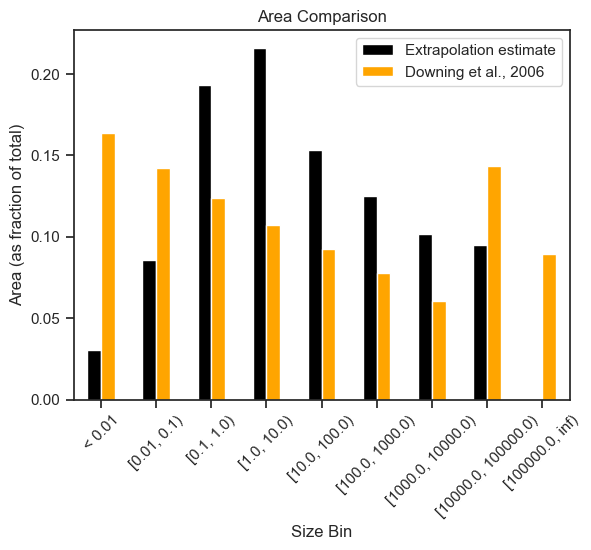

In [3]:
# Load the Excel file
df = pd.read_excel('/Users/ekyzivat/Library/CloudStorage/GoogleDrive-ethan_kyzivat@alumni.brown.edu/My Drive/Writing/Ch4/Revision1/Tables/Size_bin_table_norm_v20_Downing_save.xlsx', sheet_name='comb_bins', index_col='size_bin')

# Exclude the last row with index 'Sum'
df = df.iloc[:-1]

# Define custom colormap with black and orange
colors = ['black', 'orange']
custom_cmap = ListedColormap(colors)

# Plot the 'Area_Mkm2' and 'Downing Area norm'
fig, ax = plt.subplots()
df[['Area_Mkm2', 'Downing Area norm']].plot(kind='bar', colormap=custom_cmap, ax=ax)

# Set labels and title
ax.set_xlabel('Size Bin')
ax.set_ylabel('Area (as fraction of total)')
plt.xticks(rotation=45)
plt.title('Area Comparison')

# plt.legend(['My Arctic estimate', 'Conventional global estimate'])
plt.legend(['Extrapolation estimate', 'Downing et al., 2006'])

# Show the plot
plt.show()


# Compare to PLD global data!

In [4]:
lad = LAD.from_shapefile('/Volumes/thebe/Other/SWOT-PLD/v0.1/SWOT_PLD.gdb', name='PLD', area_var='ref_area', idx_var='lake_id', _areaConversionFactor=100, other_vars=['lon','lat'])
lad.Area_km2.sum()/1e6
# lad

2.5265799615903792

In [2]:
## PLD v103 ... not sure what happened
lad_v3 = LAD.from_shapefile('/Volumes/metis/Datasets/SWOT_PLD/SWOT_PLD_v103_beta/SWOT_PLD_v103_beta.gdb',
                         name='PLD', area_var='Shape_Area', idx_var='lake_id', _areaConversionFactor=1e-4, other_vars=['lon', 'lat'])
lad_v3.Area_km2.sum()/1e6
# lad

3.596534028711105

In [5]:
## Add Caspian Sea
caspian_shp = gpd.read_file(
    '/Volumes/thebe/HydroLAKES_polys_v10_shp/HydroLAKES_polys_v10_shp/HydroLAKES_polys_v10.shp', rows=1, engine='pyogrio', read_geometry=False)
caspian_shp
lad_caspian = LAD(caspian_shp, name='HL', area_var='Lake_area', idx_var='Hylak_id')
lad = LAD.concat((lad, lad_caspian),
                     broadcast_name=True, ignore_index=True)
lad

,Area_km2,Name,Region
0,0.0153,PLD,PLD
1,0.0207,PLD,PLD
2,0.0225,PLD,PLD
3,0.0468,PLD,PLD
4,0.2423,PLD,PLD
...,...,...,...
5988467,1.7672,PLD,PLD
5988468,1.2997,PLD,PLD
5988469,1.9816,PLD,PLD
5988470,2.5843,PLD,PLD


In [6]:
## Verify min area
lad.Area_km2.min()
lad.Area_km2.max()

377001.91

In [7]:
## Loading from CIR gdf
print('Load HR...')
regions = ['Sagavanirktok River', 'Yukon Flats Basin', 'Old Crow Flats', 'Mackenzie River Delta',
            'Mackenzie River Valley', 'Canadian Shield Margin', 'Canadian Shield', 'Slave River',
            'Peace-Athabasca Delta', 'Athabasca River', 'Prairie Potholes North',
            'Prairie Potholes South', 'Tuktoyaktuk Peninsula', 'All']
lad_cir = LAD.from_shapefile('/Volumes/thebe/Planet-SR-2/Classification/cir/dcs_fused_hydroLakes_buf_10_sum.shp',
                                area_var='Area', name='CIR', region_var='Region4', regions=regions, idx_var='OID_')

## Loading PeRL LAD
perl_exclude = ['arg0022009xxxx', 'fir0022009xxxx', 'hbl00119540701', 'hbl00119740617',
                'hbl00120060706', 'ice0032009xxxx', 'rog00219740726', 'rog00220070707',
                'tav00119630831', 'tav00119750810', 'tav00120030702', 'yak0012009xxxx',
                'bar00120080730_qb_nplaea.shp']
lad_perl = LAD.from_paths('/Volumes/thebe/PeRL/PeRL_waterbodymaps/waterbodies/*.shp',
                            area_var='AREA', name='perl', _areaConversionFactor=1000000, exclude=perl_exclude)

## Loading from Mullen
lad_mullen = LAD.from_paths('/Volumes/thebe/Other/Mullen_AK_lake_pond_maps/Alaska_Lake_Pond_Maps_2134_working/data/*_3Y_lakes-and-ponds.zip', _areaConversionFactor=1000000,
                            name='Mullen', computeArea=True)  # '/Volumes/thebe/Other/Mullen_AK_lake_pond_maps/Alaska_Lake_Pond_Maps_2134_working/data/[A-Z][A-Z]_08*.zip'

## Combine PeRL and CIR and Mullen
lad_ref = LAD.concat((lad_cir, lad_perl, lad_mullen),
                    broadcast_name=True, ignore_index=True)
compute_ci_lad=True
error_bars=True
ref_ds = 'Arctic HR'

Load HR...


In [66]:
## Alternatively, load WBD as ref
print('Load WBD...')
lad_ref = LAD.from_shapefile(
    '/Volumes/thebe/Other/Feng-High-res-inland-surface-water-tundra-boreal-NA/edk_out/fixed_geoms/WBD.shp', area_var='Area', name='WBD', idx_var='OBJECTID')
lad_ref.truncate(0.001, inplace=True)
compute_ci_lad=False
error_bars=False
ref_ds = 'WBD'

Load WBD...


In [8]:
## Simple extrap from HR
extreme_regions_lad = [
    'Tuktoyaktuk Peninsula', 'sur00120130802_tsx_nplaea']

# Truncation limits for ref LAD. tmax defines the right bound of the index region. tmin defines the leftmost bound to extrapolate to.
tmin, tmax = (0.0001, 1)

# Extrapolation limits. emax defines the left bound of the index region (and right bound of the extrapolation region).
emax = 0.05
binned_ref = BinnedLAD(lad_ref.truncate(tmin, tmax), tmin, emax, compute_ci_lad=compute_ci_lad,
                        extreme_regions_lad=extreme_regions_lad)  # reference distrib (try 5, 0.5 as second args)
# Beware chaining unless I return a new variable. # Try 0.1
lad_trunc = lad.truncate(emax, np.inf)
lad_trunc.extrapolate(binned_ref)
# meas = lad_hl_lev.sumAreas(includeExtrap=False)
# extrap = lad_hl_trunc.sumAreas()

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


Text(0.5, 1.0, 'Extrapolated from Arctic HR')

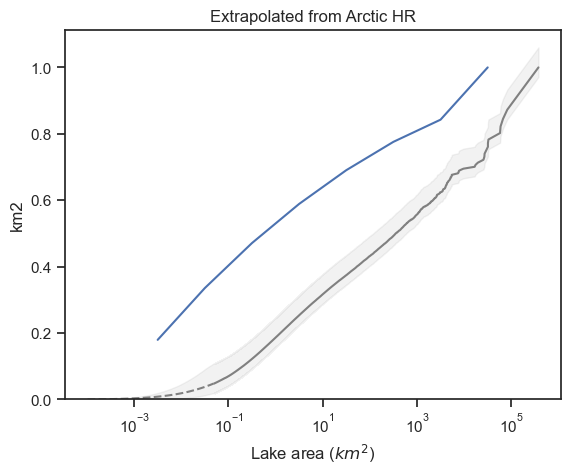

In [16]:
## Put Downing number into my BinnedLAD data structure, just to verify plot
btm = 0.001
top = 100000
nbins = 8
bin_edges = np.concatenate((np.geomspace(btm, top, nbins+1), [380000])).round(6) # bins computed from nbins and edges
area_bins = pd.IntervalIndex.from_breaks(bin_edges, closed='left')
X = bin_edges[1:] # plot against right bin edge
d06 = [692600, 602100, 523400, 455100, 392362, 329816, 257856, 607650, 378119]
group_sums = pd.Series(d06, index=area_bins, name='Area_km2') # from Downing 2006 paper
binnedAreas = confidence_interval_from_extreme_regions(group_sums, None, None, name='Area_km2') # # Why are lower/upper non NaN?? Ignore.
lad_d06 = BinnedLAD(btm=btm, top=top, nbins=nbins, binned_areas=binnedAreas, compute_ci_lad=False) # give btm, top, nbins, compute_ci_lad and binnedAreas args
# lad_d06_canon = BinnedLAD(btm=bin_edges[4], top=bin_edges[-2], nbins=4, binned_areas=confidence_interval_from_extreme_regions(group_sums[4:-1], None, None, name='Area_km2'), compute_ci_lad=False) # give btm, top, nbins, compute_ci_lad and binnedAreas args
# lad_d06_extrap = BinnedLAD(btm=bin_edges[0], top=bin_edges[4], nbins=4, binned_areas=confidence_interval_from_extreme_regions(group_sums[:4], None, None, name='Area_km2'), compute_ci_lad=False) # give btm, top, nbins, compute_ci_lad and binnedAreas args

fig, ax = plt.subplots()
lad_trunc.plot_extrap_lad(ax=ax, label='Lake area', error_bars=error_bars, normalized=True, color='grey', plotLegend=False)

lad_d06.plot(ax=ax, show_rightmost=False, as_lineplot=True, as_cumulative=True) # plot as binnedLAD, skipping top bin with Caspian Sea
plt.xscale('log')
plt.yscale('linear')
plt.title(f'Extrapolated from {ref_ds}')


In [29]:
lad_trunc.extrapLAD.binnedAreas

size_bin              stat 
[0.0001, 0.000106)    mean       68.661457
                      lower       5.212669
                      upper     107.251796
[0.000106, 0.000113)  mean      112.194229
                      lower       5.605317
                                  ...     
[0.044156, 0.046987)  lower    2909.119081
                      upper    7823.163803
[0.046987, 0.05)      mean     4786.852120
                      lower    2064.378104
                      upper    7071.675574
Name: Area_km2, Length: 300, dtype: float64

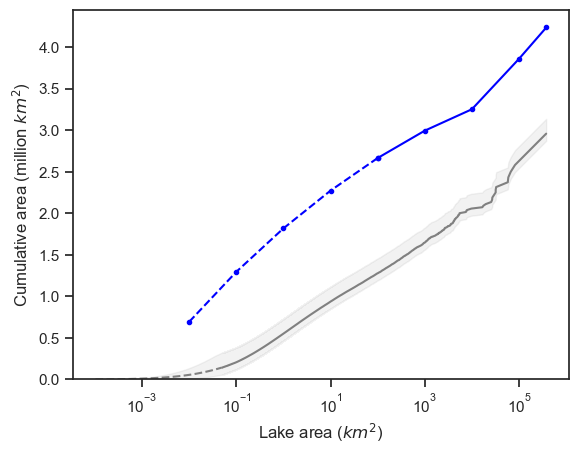

In [25]:
## Second way
fig, ax = plt.subplots()

# ## Put Downing number into my BinnedLAD data structure, just to verify plot
# lad_d06 = BinnedLAD(btm=btm, top=top, nbins=nbins, binned_areas=binnedAreas, compute_ci_lad=False) # give btm, top, nbins, compute_ci_lad and binnedAreas args
# # lad_d06_canon = BinnedLAD(btm=bin_edges[4], top=bin_edges[-2], nbins=4, binned_areas=confidence_interval_from_extreme_regions(group_sums[4:-1], None, None, name='Area_km2'), compute_ci_lad=False) # give btm, top, nbins, compute_ci_lad and binnedAreas args
# # lad_d06_extrap = BinnedLAD(btm=bin_edges[0], top=bin_edges[4], nbins=4, binned_areas=confidence_interval_from_extreme_regions(group_sums[:4], None, None, name='Area_km2'), compute_ci_lad=False) # give btm, top, nbins, compute_ci_lad and binnedAreas args
# lad_d06.plot(ax=ax, show_rightmost=False, as_lineplot=True, as_cumulative=True) # plot as binnedLAD, skipping top bin with Caspian Sea

# ax.plot(X, np.cumsum(d06)/np.sum(d06)) # units Mkm2 /1e6
d06_canonical = d06[4:]
d06_extrap = d06[:4]
ax.plot(X[:5], np.cumsum(d06[:5]) / 1e6, color='blue',
        marker='.', linestyle='dashed')
# ax.plot(X[:], np.cumsum(d06)/1e6, color='blue', marker='x',linestyle='dashed') # This time, exclude top bin to better compare with BAWLD domain # /np.sum(d06[:-1])
ax.plot(X[4:], (np.cumsum(d06_canonical)+np.sum(d06_extrap))/1e6, color='blue', marker='.') # Plot canonical # /(np.sum(d06_canonical[:-1]) + np.sum(d06_extrap))
# ax.plot(X[:4], np.cumsum(d06_extrap)/np.sum(d06[:-1]), color='orange', linestyle='dashed') # Plot extrap

## Plot WBD
lad_trunc.plot_extrap_lad(ax=ax, label='Lake area', error_bars=True, normalized=False, color='grey', plotLegend=False)


ax.set_yscale('linear')
ax.set_xscale('log')
# ax.set_xticks(X)

In [49]:
## Bin
log_bins_upper = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
# now, bin upper values for Table estimate, use regions as placeholder to get dummy CI
lad_binned = BinnedLAD(lad, bins=log_bins_upper, compute_ci_lad=False,
                                    compute_ci_lev=False, compute_ci_lev_existing=True, normalize=False)

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
/Users/ekyzivat/Library/CloudStorage/Dropbox/Python/Ch4/notebooks/../LAD.py:1754: UserWarning: The first bin has count zero. Did you set the lowest bin edge < the lower truncation limit of the dataset?
  warn('The first bin has count zero. Did you set the lowest bin edge < the lower truncation limit of the dataset?')


141364.8005704814

In [59]:
df['PLD_area'] = lad_binned.binnedAreas.loc[:, 'mean'].values
df.loc['< 0.01', 'PLD_area'] = lad_trunc.extrapLAD.sumAreas()
df

,Area_Mkm2,LEV_Mkm2,Tg_yr,DC_Mkm2,Count,Downing Area,Downing Area norm,PLD_area
size_bin,,,,,,,,
< 0.01,0.030726,0.079164,0.115097,0.054039,NaN,692600,0.163387,141364.800570
"[0.01, 0.1)",0.085423,0.225184,0.192057,0.153714,NaN,602100,0.142038,150575.290708
"[0.1, 1.0)",0.193123,0.308796,0.275720,0.270802,0.509697,523400,0.123472,344374.712527
"[1.0, 10.0)",0.216017,0.193088,0.199174,0.285146,0.454582,455100,0.107360,386206.939445
"[10.0, 100.0)",0.153222,0.093624,0.100421,0.133285,0.032917,392362,0.092560,340607.411308
"[100.0, 1000.0)",0.124829,0.058149,0.059065,0.074730,0.002571,329816,0.077805,369664.607003
"[1000.0, 10000.0)",0.101504,0.030270,0.034596,0.025054,0.000215,257856,0.060829,409590.757900
"[10000.0, 100000.0)",0.095155,0.011725,0.023870,0.003230,0.000019,607650,0.143347,525560.242700
"[100000.0, inf)",0.000000,NaN,0.000000,NaN,0.000000,378119,0.089200,377001.910000


In [63]:
df.columns

Index(['Area_Mkm2', 'LEV_Mkm2', 'Tg_yr', 'DC_Mkm2', 'Count', 'Downing  Area',
       'Downing Area norm', 'PLD_area'],
      dtype='object')

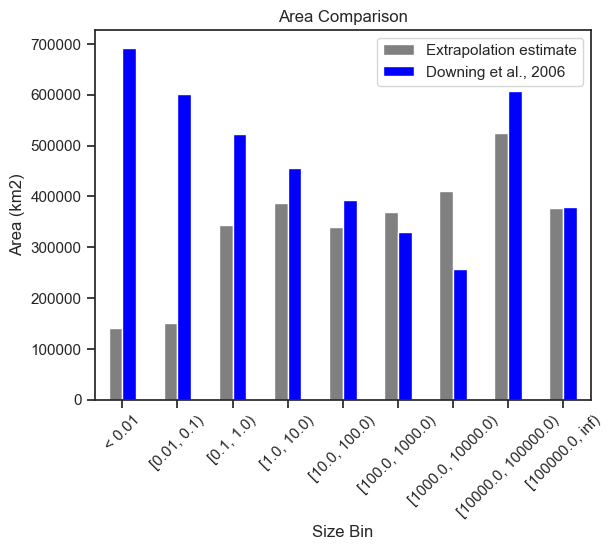

In [65]:
## Update the bar plot

# Define custom colormap with black and orange
colors = ['grey', 'blue']
custom_cmap = ListedColormap(colors)

# Plot the 'Area_Mkm2' and 'Downing Area norm'
fig, ax = plt.subplots()
df[['PLD_area', 'Downing  Area']].plot(
    kind='bar', colormap=custom_cmap, ax=ax)

# Set labels and title
ax.set_xlabel('Size Bin')
ax.set_ylabel('Area (km2)')
plt.xticks(rotation=45)
plt.title('Area Comparison')

# plt.legend(['My Arctic estimate', 'Conventional global estimate'])
plt.legend(['Extrapolation estimate', 'Downing et al., 2006'])

# Show the plot
plt.show()

In [33]:
# Orig area (note I added Caspian Sea to PLD)
lad.sumAreas(includeExtrap=False) / 1e6

# Orig area (compare to HL size domain)
# lad.truncate(0.1, np.inf).sumAreas(includeExtrap=False) / 1e6
# lad.area_fraction(0.1)

# Extrap area
# lad_trunc.sumAreas() / 1e6



2.903581871590379

# Compare to HL global dataset

In [34]:
## Load HL
lad_hl = LAD.from_shapefile('/Volumes/thebe/HydroLAKES_polys_v10_shp/HydroLAKES_polys_v10_shp/HydroLAKES_polys_v10.shp', name='HL', area_var='Lake_area', idx_var='Hylak_id', _areaConversionFactor=1)

In [35]:
## Compare to HL
lad_hl.sumAreas(includeExtrap=False) / 1e6

2.92672277

# Reproduce 2019 matlab plot I made of global lake and river area

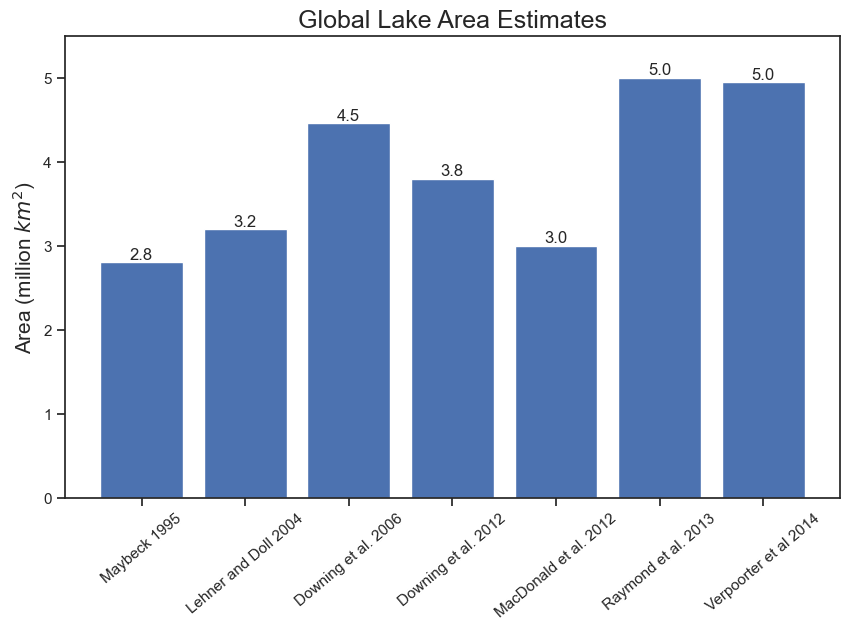

In [2]:
# 2019 Plot data (unchanged)
y = [2.803, 3.2, 4.46, 3.8, 3, 5, 4.95]
str_labels = [
    'Maybeck 1995',
    'Lehner and Doll 2004',
    'Downing et al. 2006',
    'Downing et al. 2012',
    'MacDonald et al. 2012',
    'Raymond et al. 2013',
    'Verpoorter et al 2014',
    'Holgerson and Raymond 2016',
    'Allen and Pavelsky 2018'
]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(str_labels[:len(y)], y)

# Adding data labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 1),
             verticalalignment='bottom', horizontalalignment='center',
             fontsize=12)

plt.ylabel('Area (million $km^2$)', fontsize=15)
plt.xticks(rotation=40)
plt.title('Global Lake Area Estimates', fontsize=18)
plt.ylim([0, 5.5])
plt.show()

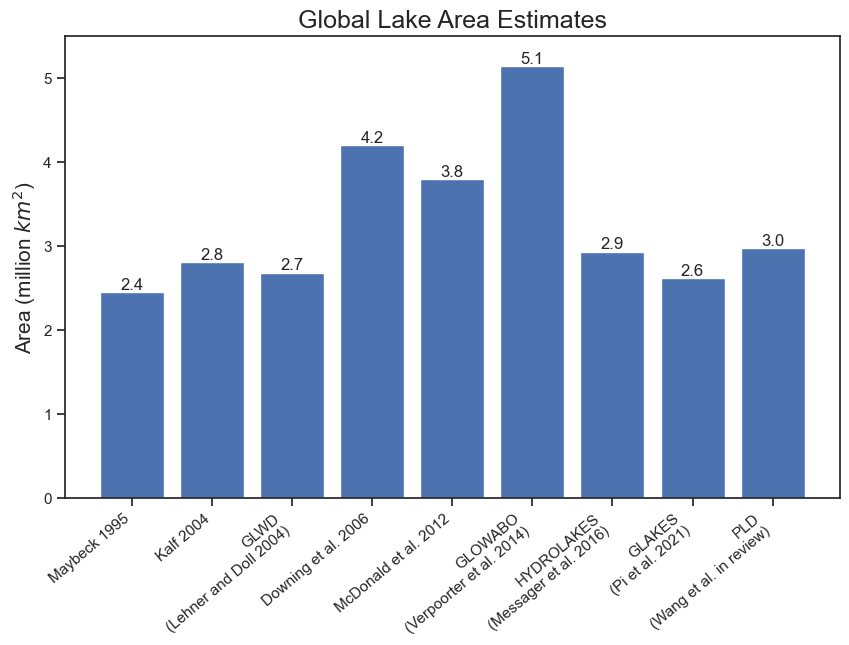

In [30]:
# Modified in 2024 to rm rivers
## See /Volumes/metis/global_lake_ch4/Global_lake_comparisons.xlsx
y = [2.45, 2.803, 2.43+0.251, 4.2, 3.79, 4.76+0.377, 2.67+0.26, 2.612, 2.597+0.377] # Maybeck
str_labels = [
    'Maybeck 1995',  # ranges 2.3 - 2.6
    'Kalf 2004', # > 1 km2
    'GLWD\n(Lehner and Doll 2004)', # includes res
    'Downing et al. 2006', # no res
    'McDonald et al. 2012',  # McDonald uses Res
    'GLOWABO\n(Verpoorter et al. 2014)', # including res here
    'HYDROLAKES\n(Messager et al. 2016)',  # res, HL paper reports 2.67 M km2, but shapefile sums to 2.927 due to reservoirs
    'GLAKES\n(Pi et al. 2021)', # res
    'PLD\n(Wang et al. in review)' # res, Caspian added
]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(str_labels, y)

# Adding data labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 1),
             verticalalignment='bottom', horizontalalignment='center',
             fontsize=12)

plt.ylabel('Area (million $km^2$)', fontsize=15)
plt.xticks(rotation=40, ha='right')
plt.title('Global Lake Area Estimates', fontsize=18)
plt.ylim([0, 5.5])
plt.show()

In [4]:
## Double check Downing number: It should read 4.24 Mkm2 (yep)
import numpy as np
d06 = [692600, 602100, 523400, 455100, 392362, 329816, 257856, 607650, 378119]
np.sum(d06)/1e6

4.239003

## Uploading PLD to GEE

Notes on uploading PLD:

Asset name: projects/ee-ekyzivat/assets/Shapes/SWOT_PLD_v103
ID: BNXCUSJEIISMJD6FC322YU65
Phase: Failed
Runtime: 12m (started 2024-01-29 14:41:10 -0500)
Attempted 1 time
Error: Could not unzip file with name 'SWOT_PLD_v103_beta.shp'. (Error code: 3)

Asset name: projects/ee-ekyzivat/assets/Shapes/SWOT_PLD_v103_beta
ID: UU2BEXT2IJC24VTDY2ZO5NAE
Phase: Failed
Runtime: 5h (started 2024-01-29 16:48:19 -0500)
Attempted 2 times
Error: Primary geometry of feature '3584985' has 1056371 vertices, above the limit of 1000000 vertices. (Error code: 3)

In [12]:
# gdf_pld = gpd.read_file(
#     '/Volumes/metis/Datasets/SWOT_PLD/SWOT_PLD_v103_beta/SWOT_PLD_v103_beta.shp', engine='pyogrio', )
gdf_pld = gpd.read_file(
    '/Volumes/metis/Datasets/SWOT_PLD/SWOT_PLD_v103_beta/SWOT_PLD_v103_beta.gdb', engine='pyogrio',
    columns=['lake_num', 'lon', 'lat', 'Shape_Length', 'Shape_Area', 'geometry'],
    bbox=(-180, 40, 180, 80))  # 'lake_id',

In [13]:
gdf_pld.iloc[-1,:]

Shape_Area                                               0.000007
Shape_Length                                              0.01904
lake_num                                                    39730
lat                                                     67.603923
lon                                                    -67.459911
geometry        MULTIPOLYGON (((-67.46195830099998 67.60192375...
Name: 4955496, dtype: object

In [14]:
from shapely.geometry import Polygon, MultiPolygon

# Create a new column to store the number of vertices
def count_vertices(geom):
    if isinstance(geom, Polygon):
        return len(geom.exterior.coords)
    elif isinstance(geom, MultiPolygon):
        return sum(len(poly.exterior.coords) for poly in geom.geoms)
    else:
        return 0


gdf_pld['num_vertices'] = gdf_pld['geometry'].apply(count_vertices)

# Print the number of vertices for each feature
print(gdf_pld['num_vertices'])

/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


0           67
1           16
2          128
3           34
4           15
          ... 
4955492     77
4955493    149
4955494    141
4955495    247
4955496     27
Name: num_vertices, Length: 4955497, dtype: int64


In [15]:
## Get Index of feature with lots of vertices, and confirm it matches GE error message
idx = gdf_pld[gdf_pld.num_vertices > 500000].index

## Replace the geometry of this feature with a simplified geometry
gdf_pld.loc[idx, 'geometry'] = gdf_pld.loc[idx,
                                           'geometry'].simplify(tolerance=150)

gdf_pld.loc[idx, 'geometry']

/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/shapely/constructive.py:881: RuntimeWarning: invalid value encountered in simplify_preserve_topology
  return lib.simplify_preserve_topology(geometry, tolerance, **kwargs)


2795237    POLYGON ((-84.75886 45.78554, -83.90913 45.958...
Name: geometry, dtype: geometry

In [16]:
## Rerun and confirm fix
gdf_pld['num_vertices'] = gdf_pld['geometry'].apply(count_vertices)

gdf_pld[gdf_pld.num_vertices > 500000]

/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


,Shape_Area,Shape_Length,lake_num,lat,lon,geometry,num_vertices


In [17]:
## Write out as Shapefile 
gdf_pld.to_file(
    '/Volumes/metis/Datasets/SWOT_PLD/SWOT_PLD_v103_beta/edk_out/SWOT_PLD_v103_beta_1simpl.shp', engine='pyogrio')

/var/folders/rv/sn0kln2103b9fs4xl56n3w7w0000gn/T/ipykernel_5742/641949962.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_pld.to_file(
/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/pyogrio/raw.py:456: RuntimeWarning: Normalized/laundered field name: 'Shape_Length' to 'Shape_Leng'
  ogr_write(
/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/pyogrio/raw.py:456: RuntimeWarning: Normalized/laundered field name: 'num_vertices' to 'num_vertic'
  ogr_write(
/Users/ekyzivat/mambaforge/envs/geo/lib/python3.11/site-packages/pyogrio/raw.py:456: RuntimeWarning: 2GB file size limit reached for /Volumes/metis/Datasets/SWOT_PLD/SWOT_PLD_v103_beta/edk_out/SWOT_PLD_v103_beta_1simpl.shp. Going on, but might cause compatibility issues with third party software
  ogr_write(


## Download global ERA5 Temps

In [14]:
import cdsapi
import numpy as np
import os
import shutil
from zipfile import ZipFile
from typing import Iterable

def download_era5_data(years: Iterable[int], months: Iterable[str], grid: Iterable[float] = [0.25, 0.1],
                        area: Iterable[float] = [85, -180, -80, 180], variables: Iterable[str] = ['lake_bottom_temperature', 'skin_temperature', 'soil_temperature_level_4', 'soil_temperature_level_1', '2m_temperature']):
    cds = cdsapi.Client()
    cds_dir = '/Volumes/thebe/Ch4/ERA5/cds'
    cds_pth = os.path.join(cds_dir, "download.netcdf.zip")

    dataset = 'reanalysis-era5-land-monthly-means'

    # Convert years to string
    years = list(map(str, years))

    params = {
        "format": "netcdf",
        "product_type": "monthly_averaged_reanalysis",
        "variable": variables,
        'year': years,
        'month': months,
        "time": "00:00",
        'format': 'netcdf.zip',
        "grid": grid,
        "area": area,
    }

    # cds.retrieve(dataset, params, cds_pth)

    # load into memory
    # with urlopen(fl.location) as f:
    #     ds = xr.open_dataset(f.read())

    # Unzip the file
    with ZipFile(cds_pth, 'r') as zip_ref:
        zip_ref.extractall(cds_dir)

    # Rename the file
    name = 'era5-land-monthly' + '_' + str(years[0]) + '_' + months[0] + '_' + str(grid[0]) + '_' + str(grid[1]) + '_' + str(area[0])+ '.nc'
    shutil.move(os.path.join(cds_dir, 'data.nc'), os.path.join(cds_dir, 'temperatures.nc'))
    print(name)

In [15]:
download_era5_data([2022], ["01", "02"], area=[
                   90, -180, 70, 180], variables=['soil_temperature_level_1'])

era5-land-monthly_2022_01_0.25_0.1_90.nc


TODO: finish testing and run to download global! (as fxn)